In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import centroid
import os
import shutil
from shapely import MultiPolygon, Polygon, wkt, intersection
import matplotlib.pyplot as plt
from geopy import distance
import pandas_geojson as pdg
import shapely
import googlemaps


In [36]:
def get_raw_precinct_gpd(filename='../project_data/chc/ChicagoPrecincts2012_2022.csv'):
    precs = pd.read_csv(filename)
    precs['precinct_id'] = precs.PRECINCT*100 + precs.WARD
    precs['the_geom'] = precs['the_geom'].apply(wkt.loads)
    precs = precs.rename(columns={'the_geom':'geometry'})
    precs = precs.drop(['FULL_TEXT', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1)
    precs['centroid'] = centroid(precs.geometry)

    precs_gpd = gpd.GeoDataFrame(precs, crs='epsg:4326')
    
    return precs_gpd.set_index('precinct_id')

def get_raw_simplex_gpd(filename='../project_data/chc/chc_death_simplices_by_death_in_dim_1.npy'):
    
    dsimps = np.load(filename, allow_pickle=True)
    dsimps_dict = dict(zip(['geometry','death_filtration_value','death_filtration_zscore','death_birth_ratio'],dsimps.T))
    dsimps_gpd = gpd.GeoDataFrame(dsimps_dict, crs='epsg:4326')
    dsimps_gpd['dsimp_index']= dsimps_gpd.index.values

    return dsimps_gpd

def get_raw_polls_gpd(filename = '../project_data/chc/Polling_Places_Chicago_2016.csv'):

    polls = pd.read_csv(filename)
    polls_gpd = gpd.GeoDataFrame()
    polls_gpd['precinct_id'] = polls.Precinct.astype(int)
    polls_gpd['polling_name'] = polls['Polling Place Name']
    polls_gpd['polling_address'] = polls['Address Line 1']
    polls_gpd['polling_description'] = polls['Description']
    polls_gpd['polling_accessible'] = 1 * (polls['Accessible'] == 'Y')
    polls_gpd['polling_zip'] = polls['Zip']
    polls_gpd['polling_lat'] = polls['lat']
    polls_gpd['polling_lon'] = polls['lon']



    return polls_gpd.set_index('precinct_id')


In [38]:
def append_intersecting_simplex_data_to_precinct(precs,dsimps_filename = '../project_data/chc/chc_death_simplices_by_death_in_dim_1.npy'):
    
    dsimps = get_raw_simplex_gpd(dsimps_filename)

    n_intersect = []
    mean_dfv = []
    indices = []

    for ii, prec in precs.iterrows():
        dfvs_ii = []
        indices_ii = []
        
        
        for jj, dsimp in dsimps.iterrows():
    
            if not intersection(prec.geometry,dsimp.geometry).area == 0:
                
                indices_ii.append(str(dsimp.dsimp_index))
                dfvs_ii.append(dsimp.death_filtration_value)
                
        if len(dfvs_ii) == 0:
            mean_dfv.append(0)
            indices.append('')
        else:
            mean_dfv.append(np.mean(dfvs_ii))
            indices.append('_'.join(indices_ii))
                            
        n_intersect.append(len(indices_ii))


    precs['dsimp_n_intersect'] = n_intersect
    precs['dsimp_mean_dfv'] = mean_dfv
    precs['dsimp_indices'] = indices
    return precs

def append_polls_to_precinct(precs, polls_filename = '../project_data/chc/Polling_Places_Chicago_2016.csv'):
    
    polls = get_raw_polls_gpd(polls_filename)

    precs = precs.join(polls)

    imputed = []
    precs_with = precs[precs.polling_lat != -999]
    
    counter = 0
    for ii, prec in precs.iterrows():
        if counter % 100 == 0: print(counter)
        counter += 1
        if prec.polling_lat != -999: 
            imputed.append(0)
            continue
        
        min_dist = None
        nearest_id = None
        for jj, poll in precs_with.iterrows():
   
            dist = distance.distance(prec.centroid.__geo_interface__['coordinates'][::-1],(poll.polling_lat,poll.polling_lon)).km
            if min_dist is None or dist < min_dist:
                min_dist = dist
                nearest_id = jj
        imputed.append(1)
        precs.loc[ii, 'polling_address'] = precs_with.loc[nearest_id].polling_address
        precs.loc[ii, 'polling_name'] = precs_with.loc[nearest_id].polling_name
        precs.loc[ii, 'polling_description'] = precs_with.loc[nearest_id].polling_description
        precs.loc[ii, 'polling_accessible'] = precs_with.loc[nearest_id].polling_accessible
        precs.loc[ii, 'polling_zip'] = precs_with.loc[nearest_id].polling_zip
        precs.loc[ii, 'polling_lat'] = precs_with.loc[nearest_id].polling_lat
        precs.loc[ii, 'polling_lon'] = precs_with.loc[nearest_id].polling_lon
        
    precs['polling_imputed'] = imputed




    return precs
    
def add_census_indices(precs,cen):
    census_indices = []
    for ii, prec in precs.iterrows():
    
        total_area = 0
        prec_area = prec.geometry.area
        indices = []
    
        for jj, block in cen.iterrows():
            area_int = intersection(prec.geometry,block.geometry).area
            if area_int == 0: continue
            else:
                indices.append(str(jj))
                total_area += area_int
        if not len(indices) == 0:
            census_indices.append('_'.join(indices))
        else:
            census_indices.append('')
    precs['census_indices'] = census_indices

    return precs
        
def index_str_to_list(s):
    indices_str = s.split('_')
    if indices_str == ['']:
        return []
    indices = [int(index) for index in indices_str]

    return indices    
    
def average_census_blocks(indices, prec, census_gpd, stat_name):
    prec_area = prec.geometry.area
    total_area = 0
    cum_stat = 0
    total_pop = 0

    for ii in indices:
        tract = census_gpd.iloc[ii].fillna(0)
 
        tract_area = tract.geometry.area
        int_area = intersection(prec.geometry,tract.geometry).area
        frac_tract = int_area/tract_area
        intersection_population = tract.total_population * frac_tract
        stat = tract[stat_name]
        if np.isnan(intersection_population):
            intersection_population = 0
            stat = 0
        total_pop += intersection_population
        total_area += int_area
        weighted_stat = tract[stat_name] * intersection_population

        cum_stat += weighted_stat
    if total_pop == 0:
        cum_stat = total_pop = np.nan
        
    return cum_stat / total_pop, total_pop, total_area/prec_area
        

# NOTE: The census data is missing 16 tracts where there is no median income data. 
# Check total_area/prec_area to see where these missing tracts show up 

def add_census_stat(precs, census_gpd, stat_name):
    
    stats = []
    area_fracs = []
    total_populations = []
    for ii, prec in precs.iterrows():
        indices = index_str_to_list(prec.census_indices)
        stat, total_pop, area_frac = average_census_blocks(indices, prec, cen, stat_name)
        
        stats.append(stat)
        area_fracs.append(area_frac)
        total_populations.append(total_pop)

    if not 'total_population_cen' in precs.columns:
        precs['total_population_cen'] = total_populations
        precs['frac_area_cen'] = area_fracs
    precs['{}_cen'.format(stat_name)] = stats 

    
def add_transit_duration(precs, transit_mode):
    with open('../../../google_maps_api','r') as f:
        my_key = f.read().strip()
    gmaps = googlemaps.Client(key=my_key)

    precs['centroid'] = centroid(precs.geometry)
    durations = []
    count = 0
    for ii, prec in precs.iterrows():
        if count % 100 == 0:
            print(count)
        count += 1
        address = prec.polling_address + ', Chicago, IL'
        lon, lat = prec.centroid.__geo_interface__['coordinates']
        result = gmaps.directions(origin=(lat,lon), destination = address, mode=transit_mode)
        if result == []:
            durations.append(999)
            continue
        duration = result[0]['legs'][0]['duration']['value']
        duration = duration / 60.
        durations.append(duration)
    precs['{}_travel_time'.format(transit_mode)] = durations

    return precs

        

In [80]:
cen = gpd.read_file('../project_data/chc/Chicago_geocensus_data.geojson')
# precs = get_raw_precinct_gpd()
# precs = append_intersecting_simplex_data_to_precinct(precs)
# precs = append_polls_to_precinct(precs)
# precs = add_census_indices(precs,cen)
# precs.to_file('../project_data/processed_Chicago_precinct_data.geojson')     
# DON'T NEED TO RUN ABOVE
precincts = gpd.read_file('../project_data/processed_Chicago_precinct_data.geojson')

We now append each census stat (scaled by things like total population) to `precincts`.

In [82]:
# These stats are scaled by total population
for stat in ['white_alone', 'black_alone', 'indigenous_alone', 'asian_alone',
       'pacific_islander_alone', 'other_alone', 'multiracial',
       'work_from_home', 'automobile_to_work', 'public_transit_to_work',
       'taxi_to_work', 'motorcycle_to_work', 'bike_to_work', 'walk_to_work',
       'other_to_work']:
    cen['{}_percent'.format(stat)] = cen[stat]/cen['total_population']
    add_census_stat(precincts, cen, '{}_percent'.format(stat))

# These are scaled by total population 18 up
for stat in ['<9th', 'no_diploma', 'high_school', 'some_college', 'associates', 'bachelors', 'graduate_degree']:
    cen['{}_percent'.format(stat)] = cen[stat]/cen['total_population_18_up']
    add_census_stat(precincts, cen, '{}_percent'.format(stat))

# These are scaled by total_pop_20_64_for_employment
for stat in ['in_labor_force_20_64', 'not_in_labor_force_20_64', 'unemployed_20_64']:
    cen['{}_percent'.format(stat)] = cen[stat]/cen['total_pop_20_64_for_employment']
    add_census_stat(precincts, cen, '{}_percent'.format(stat))

In [83]:
cen['below_poverty_line_percent'] = cen['below_poverty_line']/cen['poverty_total']
add_census_stat(precincts, cen, 'below_poverty_line_percent')

add_census_stat(precincts, cen, 'median_household_income')
add_census_stat(precincts, cen, 'median_age')

In [84]:
precincts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   precinct_id                           2069 non-null   int32   
 1   WARD                                  2069 non-null   int32   
 2   PRECINCT                              2069 non-null   int32   
 3   centroid                              2069 non-null   object  
 4   dsimp_n_intersect                     2069 non-null   int32   
 5   dsimp_mean_dfv                        2069 non-null   float64 
 6   dsimp_indices                         2069 non-null   object  
 7   polling_name                          2069 non-null   object  
 8   polling_address                       2069 non-null   object  
 9   polling_description                   2069 non-null   object  
 10  polling_accessible                    2069 non-null   int32   
 

<Axes: >

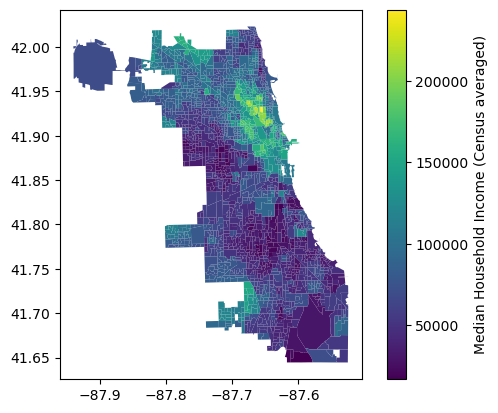

In [85]:
precincts.plot(column='median_household_income_cen',legend=True,legend_kwds={"label": "Median Household Income (Census averaged)"})


## Append the voter turnout data

In [99]:
turnout = pd.read_csv('../project_data/chc/precinct_turnout.csv')

Add the precinct_id column to `turnout`, set it as the index, and only keep the relevant columns.

In [100]:
turnout['precinct_id'] = turnout['Precinct']*100 + turnout['Ward']
turnout = turnout[['precinct_id', 'VoterTurnoutPercentage']]
turnout = turnout.set_index('precinct_id')

Join `precincts` and `turnout`.

In [102]:
precincts_with_turnout = precincts.join(turnout, on='precinct_id')

In [104]:
precincts_with_turnout

,WARD,PRECINCT,centroid,dsimp_n_intersect,dsimp_mean_dfv,dsimp_indices,polling_name,polling_address,polling_description,polling_accessible,...,associates_percent_cen,bachelors_percent_cen,graduate_degree_percent_cen,in_labor_force_20_64_percent_cen,not_in_labor_force_20_64_percent_cen,unemployed_20_64_percent_cen,below_poverty_line_percent_cen,median_household_income_cen,median_age_cen,VoterTurnoutPercentage
precinct_id,,,,,,,,,,,,,,,,,,,,,
1239,39,12,POINT (-87.72461880245619 41.97129915819269),2,4200.148551,105_149,VOLTA SCHOOL,4950 NAVERS AVE,PUBLIC SCHOOL,0,...,0.066438,0.197076,0.107223,0.826030,0.173970,4.928654e-02,0.158649,65137.380531,36.748567,68.42
3939,39,39,POINT (-87.73242195808103 41.98361395274904),2,4200.148551,105_149,BRYNFORD BIBLE CHURCH,5700 NPULASKI RD,CHURCH,1,...,0.071371,0.168694,0.344688,0.599542,0.400458,1.069478e-09,0.077228,104106.998662,50.000000,74.83
140,40,1,POINT (-87.69528809595835 41.979813925179414),1,3895.679191,83,CHICAGO POLICE STATION,5400 NLINCOLN AVE,POLICE STATION,1,...,0.059672,0.277049,0.137377,0.805059,0.194941,7.709295e-02,0.195156,58293.000276,36.500000,68.44
240,40,2,POINT (-87.69690468426742 41.986853849660186),2,4033.985941,83_129,MATHER HIGH SCHOOL,5835 NLINCOLN AVE,PUBLIC SCHOOL,1,...,0.057365,0.187052,0.096087,0.826947,0.173053,1.202104e-02,0.125710,71953.000032,40.600000,72.99
540,40,5,POINT (-87.6963672034711 41.97390993162593),2,3917.361762,83_100,ST DEMETRIOS GREEK ORTHODOX CH,2728 WCARMEN AVE,CHURCH,1,...,0.048742,0.395038,0.253563,0.901912,0.098088,4.400576e-02,0.040263,99623.999915,37.400000,73.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,26,46,POINT (-87.69389423146943 41.894648933001356),1,4003.755677,107,SMITH PARK,2526 WGRAND AVE,PARK DISTRICT FIELD HOUSE,1,...,0.039811,0.348305,0.268697,0.921601,0.078399,2.173651e-02,0.054025,131809.936580,36.638035,71.40
907,7,9,POINT (-87.55844176718996 41.76171363011985),0,0.000000,,EXCEL ACADEMY/ SOUTH SHORE,7530 SSOUTH SHORE DR,PUBLIC SCHOOL,1,...,0.079312,0.075408,0.083215,0.734792,0.265208,7.131465e-02,0.440663,37122.000000,34.500000,73.95
2804,4,28,POINT (-87.61247072744182 41.84094049747346),0,0.000000,,PRAIRIE SHORES APTS,2901 SM L KING DR,APARTMENT BUILDING,1,...,0.044964,0.358309,0.389874,0.734317,0.265683,4.864788e-02,0.146076,60754.793168,32.184832,80.11


Export this to file.

In [29]:
precincts_with_turnout.to_file('../project_data/chc/Chicago_precinct_data_with_turnout.geojson')

In [30]:
precincts_with_turnout

,precinct_id,WARD,PRECINCT,centroid,dsimp_n_intersect,dsimp_mean_dfv,dsimp_indices,polling_name,polling_address,polling_description,...,bachelors_percent_cen,graduate_degree_percent_cen,in_labor_force_20_64_percent_cen,not_in_labor_force_20_64_percent_cen,unemployed_20_64_percent_cen,below_poverty_line_percent_cen,median_household_income_cen,median_age_cen,VoterTurnoutPercentage,geometry
0,1239,39,12,POINT (-87.72461880245619 41.97129915819269),2,4200.148551,105_149,VOLTA SCHOOL,4950 NAVERS AVE,PUBLIC SCHOOL,...,0.197076,0.107223,0.826030,0.173970,4.928654e-02,0.158649,65137.380531,36.748567,68.42,"MULTIPOLYGON (((-87.72263 41.97442, -87.72265 ..."
1,3939,39,39,POINT (-87.73242195808103 41.98361395274904),2,4200.148551,105_149,BRYNFORD BIBLE CHURCH,5700 NPULASKI RD,CHURCH,...,0.168694,0.344688,0.599542,0.400458,1.069478e-09,0.077228,104106.998662,50.000000,74.83,"MULTIPOLYGON (((-87.72843 41.98283, -87.72841 ..."
2,140,40,1,POINT (-87.69528809595835 41.979813925179414),1,3895.679191,83,CHICAGO POLICE STATION,5400 NLINCOLN AVE,POLICE STATION,...,0.277049,0.137377,0.805059,0.194941,7.709295e-02,0.195156,58293.000276,36.500000,68.44,"MULTIPOLYGON (((-87.69304 41.98188, -87.69301 ..."
3,240,40,2,POINT (-87.69690468426742 41.986853849660186),2,4033.985941,83_129,MATHER HIGH SCHOOL,5835 NLINCOLN AVE,PUBLIC SCHOOL,...,0.187052,0.096087,0.826947,0.173053,1.202104e-02,0.125710,71953.000032,40.600000,72.99,"MULTIPOLYGON (((-87.69569 41.9886, -87.69568 4..."
4,540,40,5,POINT (-87.6963672034711 41.97390993162593),2,3917.361762,83_100,ST DEMETRIOS GREEK ORTHODOX CH,2728 WCARMEN AVE,CHURCH,...,0.395038,0.253563,0.901912,0.098088,4.400576e-02,0.040263,99623.999915,37.400000,73.21,"MULTIPOLYGON (((-87.69203 41.97404, -87.69242 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,4626,26,46,POINT (-87.69389423146943 41.894648933001356),1,4003.755677,107,SMITH PARK,2526 WGRAND AVE,PARK DISTRICT FIELD HOUSE,...,0.348305,0.268697,0.921601,0.078399,2.173651e-02,0.054025,131809.936580,36.638035,71.40,"MULTIPOLYGON (((-87.69167 41.89233, -87.69189 ..."
2065,907,7,9,POINT (-87.55844176718996 41.76171363011985),0,0.000000,,EXCEL ACADEMY/ SOUTH SHORE,7530 SSOUTH SHORE DR,PUBLIC SCHOOL,...,0.075408,0.083215,0.734792,0.265208,7.131465e-02,0.440663,37122.000000,34.500000,73.95,"MULTIPOLYGON (((-87.55768 41.76303, -87.55765 ..."
2066,2804,4,28,POINT (-87.61247072744182 41.84094049747346),0,0.000000,,PRAIRIE SHORES APTS,2901 SM L KING DR,APARTMENT BUILDING,...,0.358309,0.389874,0.734317,0.265683,4.864788e-02,0.146076,60754.793168,32.184832,80.11,"MULTIPOLYGON (((-87.60881 41.84525, -87.609 41..."
2067,1004,4,10,POINT (-87.59354078846704 41.812632005894706),0,0.000000,,KENNICOTT PARK,4434 SLAKE PARK AVE,PARK DISTRICT FIELD HOUSE,...,0.230900,0.257086,0.817414,0.182586,9.522283e-02,0.077633,79315.108766,32.266653,74.13,"MULTIPOLYGON (((-87.58708 41.81144, -87.58751 ..."


## Add travel times from precinct center to assigned polling location

In [40]:
precincts_with_turnout.from_file('../project_data/chc/Chicago_precinct_data_with_turnout.geojson')
for mode in ['transit','driving','walking']:
    print(mode)
    precincts_with_turnout = add_transit_duration(precincts_with_turnout, mode)
    
precincts_with_turnout['walking_transit_travel_time'] = precincts_with_turnout[['walking_travel_time','transit_travel_time']].min(axis=1)



transit
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
driving
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
walking
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


Can only save data if there's one geometry column. Converting centroid column to string. Don't worry about error message. Centroids are approximately correct anyway. Chicago is locally flat

In [53]:
precincts_with_turnout['centroid'] = precincts_with_turnout.centroid.astype(str)

/tmp/ipykernel_212597/3715326974.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  precincts_with_turnout['centroid'] = precincts_with_turnout.centroid.astype(str)


In [54]:
precincts_with_turnout.to_file('../project_data/chc/Chicago_precinct_data_with_turnout.geojson')

## Drop NA rows and save to file

In [56]:
precincts_with_turnout = precincts_with_turnout.dropna()


In [58]:
precincts_with_turnout.to_file('../project_data/chc/Chicago_precinct_data_with_turnout_no_null.geojson')

## List the features we'll use

In [1]:
precincts_with_turnout=gpd.read_file('../project_data/chc/Chicago_precinct_data_with_turnout_no_null.geojson')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'gpd' is not defined

In [60]:
features = ['white_alone_percent_cen', 'black_alone_percent_cen',
       'indigenous_alone_percent_cen', 'asian_alone_percent_cen',
       'pacific_islander_alone_percent_cen', 'other_alone_percent_cen',
       'multiracial_percent_cen', 'work_from_home_percent_cen',
       'automobile_to_work_percent_cen', 'public_transit_to_work_percent_cen',
       'taxi_to_work_percent_cen', 'motorcycle_to_work_percent_cen',
       'bike_to_work_percent_cen', 'walk_to_work_percent_cen',
       'other_to_work_percent_cen', '<9th_percent_cen',
       'no_diploma_percent_cen', 'high_school_percent_cen',
       'some_college_percent_cen', 'associates_percent_cen',
       'bachelors_percent_cen', 'graduate_degree_percent_cen',
       'in_labor_force_20_64_percent_cen',
       'not_in_labor_force_20_64_percent_cen', 'unemployed_20_64_percent_cen',
       'below_poverty_line_percent_cen', 'median_household_income_cen',
       'median_age_cen', 'polling_accessible','walking_transit_travel_time','driving_travel_time']

# Train Test Split

NOTE: The O'hare airport and industrial zone don't have walking directions. These are our outliers that we've discussed anyway. Can be identified with walking_travel_tile == 999. Saving "no_outlier" version with these removed. These are precincts 434 and 1824. Inference done with travel times should be done with the no_outlier version of the data set 

In [73]:
precincts_with_turnout[(precincts_with_turnout.walking_travel_time==999)]

,precinct_id,WARD,PRECINCT,centroid,dsimp_n_intersect,dsimp_mean_dfv,dsimp_indices,polling_name,polling_address,polling_description,...,unemployed_20_64_percent_cen,below_poverty_line_percent_cen,median_household_income_cen,median_age_cen,VoterTurnoutPercentage,transit_travel_time,driving_travel_time,walking_travel_time,walking_transit_travel_time,geometry
434,1310,10,13,POINT (-87.57628 41.685081),2,5759.069078,167_170,ORVILLE BRIGHT SCHOOL,10740 SCALHOUN AVE,PUBLIC SCHOOL,...,0.116391,0.356675,29835.822639,34.836133,60.22,999.000000,7.300000,999.0,999.000000,"MULTIPOLYGON (((-87.57366 41.70797, -87.57244 ..."
1824,2741,41,27,POINT (-87.903676 41.97928),4,4416.785007,60_93_153_169,ST JOSEPH UKRANIAN CHURCH,5000 NCUMBERLAND AVE,CHURCH,...,0.039718,0.078996,68282.813460,39.345610,65.06,28.416667,10.433333,999.0,28.416667,"MULTIPOLYGON (((-87.89598 42.00578, -87.89598 ..."


In [74]:
precincts_with_turnout.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   precinct_id                           2059 non-null   int32   
 1   WARD                                  2059 non-null   int32   
 2   PRECINCT                              2059 non-null   int32   
 3   centroid                              2059 non-null   object  
 4   dsimp_n_intersect                     2059 non-null   int32   
 5   dsimp_mean_dfv                        2059 non-null   float64 
 6   dsimp_indices                         2059 non-null   object  
 7   polling_name                          2059 non-null   object  
 8   polling_address                       2059 non-null   object  
 9   polling_description                   2059 non-null   object  
 10  polling_accessible                    2059 non-null   int32   
 

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(precincts_with_turnout, test_size=0.20, random_state=190521)

X_train.to_file('../project_data/final_dataset/train_final_dataset_Chicago.geojson')
X_test.to_file('../project_data/final_dataset/test_final_dataset_Chicago.geojson')

X_train_no_outlier = X_train[~(X_train.walking_travel_time==999)]
X_test_no_outlier = X_test[~(X_test.walking_travel_time==999)]

X_train_no_outlier.to_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X_test_no_outlier.to_file('../project_data/final_dataset/test_final_dataset_Chicago_no_outlier.geojson')




In [76]:
X_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1647 entries, 377 to 1307
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   precinct_id                           1647 non-null   int32   
 1   WARD                                  1647 non-null   int32   
 2   PRECINCT                              1647 non-null   int32   
 3   centroid                              1647 non-null   object  
 4   dsimp_n_intersect                     1647 non-null   int32   
 5   dsimp_mean_dfv                        1647 non-null   float64 
 6   dsimp_indices                         1647 non-null   object  
 7   polling_name                          1647 non-null   object  
 8   polling_address                       1647 non-null   object  
 9   polling_description                   1647 non-null   object  
 10  polling_accessible                    1647 non-null   int32   
 11 

In [65]:
X_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 412 entries, 1058 to 1215
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   precinct_id                           412 non-null    int32   
 1   WARD                                  412 non-null    int32   
 2   PRECINCT                              412 non-null    int32   
 3   centroid                              412 non-null    object  
 4   dsimp_n_intersect                     412 non-null    int32   
 5   dsimp_mean_dfv                        412 non-null    float64 
 6   dsimp_indices                         412 non-null    object  
 7   polling_name                          412 non-null    object  
 8   polling_address                       412 non-null    object  
 9   polling_description                   412 non-null    object  
 10  polling_accessible                    412 non-null    int32   
 11 

In [78]:
X_train_no_outlier.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1646 entries, 377 to 1307
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   precinct_id                           1646 non-null   int32   
 1   WARD                                  1646 non-null   int32   
 2   PRECINCT                              1646 non-null   int32   
 3   centroid                              1646 non-null   object  
 4   dsimp_n_intersect                     1646 non-null   int32   
 5   dsimp_mean_dfv                        1646 non-null   float64 
 6   dsimp_indices                         1646 non-null   object  
 7   polling_name                          1646 non-null   object  
 8   polling_address                       1646 non-null   object  
 9   polling_description                   1646 non-null   object  
 10  polling_accessible                    1646 non-null   int32   
 11 

In [79]:
X_test_no_outlier.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 411 entries, 1058 to 1215
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   precinct_id                           411 non-null    int32   
 1   WARD                                  411 non-null    int32   
 2   PRECINCT                              411 non-null    int32   
 3   centroid                              411 non-null    object  
 4   dsimp_n_intersect                     411 non-null    int32   
 5   dsimp_mean_dfv                        411 non-null    float64 
 6   dsimp_indices                         411 non-null    object  
 7   polling_name                          411 non-null    object  
 8   polling_address                       411 non-null    object  
 9   polling_description                   411 non-null    object  
 10  polling_accessible                    411 non-null    int32   
 11 